# Project Template

You can use this notebook as a template for your project. Besides having all the requisite sections, it has some code snippets that should help you accomplish some of the tasks that your project may require.

The goals of this exercise are
- to give you an opportunity to explore an interesting mechanical system and exercise your creativity
- to develop your skills using Python, MatPlotLib, numpy, and scipy to simulate the motion of a mechanical system
- to use your simulations to investigate the behavior of the system you have chosen
- to share your results with the class

Projects will be done in teams of three. We can use Sakai or Discord as a clearinghouse for folks to find project partners.

## Possible systems to investigate

Many of the following involve pendulums of some sort. You should think of the masses as being attached to the end of very light, rigid rods, which therefore allow them to assume an inverted configuration.

1. A double pendulum, which is a simple pendulum suspended from a simple pendulum. [Here's an example of a single one](https://sakai.claremont.edu/access/content/group/CX_mtg_HMCPhysics24ASP21/Lab/oneDP.mp4) and [Here are five identical ones started at slightly different positions](https://sakai.claremont.edu/access/content/group/CX_mtg_HMCPhysics24ASP21/Lab/fiveDP.mp4).
2. A single pendulum whose top is vibrated horizontally by $X = A \sin(\omega t)$, where $A$ and $\omega$ are parameters you can vary.
3. A single pendulum whose top is vibrated vertically by $X = A \sin(\omega t)$, where $A$ and $\omega$ are parameters you can vary. For certain values of the parameters, you can stabilize the pendulum in the upside down orientation!
4. The Magnetron toy (https://sakai.claremont.edu/access/content/group/CX_mtg_HMCPhysics24ASP21/Lab/Magnetron.mp4) — I'll be happy to help with the magnetism part here.
5. [A “gas” of hard disks in a finite box](https://saeta.physics.hmc.edu/MD/) interacting only by bouncing off each other elastically.
6. A “gas” of particles interacting via a potential, such as the 6-12 or Lennard-Jones potential. 
7. A bunch of metronomes resting on a platform that can move. See https://www.youtube.com/watch?v=5v5eBf2KwF8&t=181s or https://www.youtube.com/watch?v=Ov3aeqjeih0 or just search for *synchronized metronomes* on YouTube.
8. Because it rotates, our Sun is not spherical but oblate. Therefore, the gravitational force it exerts on a planet should be described by $$ F = - \frac{G M m}{r^2} - G Q \frac{m}{r^4} $$ where the quadrupole moment $Q$ is a constant proportional to the oblateness. Investigate how the quadrupole moment affects planetary orbits.
9. A planet in the vicinity of a binary star system. [There are notes on Sakai](https://sakai.claremont.edu/access/content/group/CX_mtg_145663/Lab/BinaryStar.pdf).
10. Two moons of Saturn, Janus and Epimetheus, have almost identical orbits, which makes them seem to almost bounce off each other every four years or so. See [the NASA page](https://solarsystem.nasa.gov/moons/saturn-moons/epimetheus/in-depth/) for a description of this remarkable system.
11. A chaotic water wheel.
12. A dripping faucet.
13. Orbits in the vicinity of Lagrange points.
14. A system of your own devising (after you run it by me).

In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
from p24asolver import P24ASolver

## Example investigation

To illustrate how to use the `P24ASolver` class, I will explore an extension to the driven damped harmonic oscillator demonstration that we looked at in class. In this case, I'll add a second cart whose mass can be adjusted. For simplicity, all the springs will be the same, and I assume that the right end of the rightmost spring is driven with amplitude $D$ and angular frequency $\omega$. Each mass has its own linear damper, too.
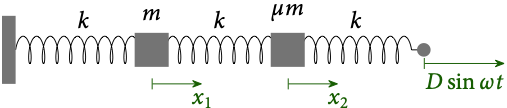

Let's first find the equations of motion. Isolating the left mass, we get $$ m \ddot{x}_1 = -k x_1 + k(x_2 - x_1) - b_1 \dot{x}_1 = k(x_2 - 2 x_1) - b_1 \dot{x}_1 $$ and $$ \mu m \ddot{x}_2 = k(D\sin\omega t - x_2) + k(x_1 - x_2) - b_2 \dot{x}_2$$
Let's divide through by $m$, define $\omega_0^2 = k/m$, and $\zeta_n = \frac{b_n}{2 m \omega_0}$.
Then the equations become
\begin{align}
  \ddot{x}_1 &= -2 \omega_0 \zeta_1 \dot{x}_1 + \omega_0^2(x_2 - 2 x_1) \\
  \ddot{x}_2 &= - \frac{2 \omega_0 \zeta_2 }{\mu} \dot{x}_2 + \frac{\omega_0^2}{\mu} (D \sin\omega t + x_1 - 2 x_2)
\end{align}

With no loss of generality, we can simply choose $\omega_0 = 2\pi$ and then investigate behavior for different drive amplitude $D$, mass ratio $\mu$, and damping parameters $\zeta_1$ and $\zeta_2$.

To simulate this system we will need four coordinates: $x_1$, $v_1$, $x_2$, and $v_2$. So, our first job is to subclass `P24ASolver` and supply an `__init__` method that will accept the values of the parameters and store them conveniently, and provide names and LaTeX representations for use in figures. Then we add a `derivatives` method that takes in the time and current coordinates and returns the derivatives.

As a bonus, I’m also going to implement the routines to make animations.

In [2]:
class pluto(P24ASolver):
    """
    Simulate a planet orbiting the sun with another body in the same orbit.
    """

    def __init__(self, **kwargs):
        super().__init__(
            (('r', '$r_1$'), ('rDot', r'$\dot{r}$'),
             ('rj', '$rj$'), ('rjDot', '$rjDot$'), ('theta', r'$theta'), ('thetaDot', '$thetaDot$'), ('jTheta', '$jTheta$'), ('jThetaDot2', '$jThetaDot2$'))
        )
        # m is the small negligible mass, mj is planet
        # note, in solar masses/AU/years, GMs= 4pi^2
        self.rj = kwargs.get('rj', 5.2) # planet radius in AU
        self.mj = kwargs.get('mj', 9.5e-4) # planet mass in solar masses
        self.jInitialTheta = kwargs.get('jInitialTheta', 0) # initial planet angle
        self.r = kwargs.get('r', 5.2) # small body radius same as jupiter to start out
        self.m = kwargs.get('m', 2.71e7) #small body mass of moon in solar masses
        self.initialTheta = kwargs.get('initialTheta', np.pi/2) # initial angle of body
        self.rtol = kwargs.get('rtol', 1e-10)
        self.atol = kwargs.get('atol', 1e-10)

    def __str__(self):
        "Produce a string representation of the parameters"
        #fmt = r"$rj = {69911000:.2g}, mj = {1.898e27:.2g}, jInitialTheta = {m = {69911000:.2g}, jInitialTheta = {0:.2g}"
        # i didn't feel like doing this so i left it for now
        return fmt.format(self.R, self.m1, self.m2)

    def derivatives(self, t, Y):
        GMs = 4*np.pi**2 #big G times mass of sun
        jThetaDot = np.sqrt(GMs/(self.rj)**3) # a constant because assuming negligible mass of planetesimal
        r, rDot, rj, rjDot, theta, thetaDot, jTheta, jThetaDot2 = Y  # unpack the values, jThetaDot2 because jThetaDot is pre loaded
        sSquared = r**2 + self.rj**2 - 2*r*self.rj*np.cos(theta - jTheta)#distance between the masses squared
        theta3 = np.arccos((self.rj**2-sSquared-r**2)/(-2*np.sqrt(sSquared)*r)) #angle between sun and planet with planetesimal as axis
        rDDot = -1 * (GMs/r**2 + GMs*self.mj*np.cos(theta3)/sSquared) + r*thetaDot**2
        thetaDDot = -GMs*self.mj/(r*sSquared) - 2*thetaDot*rDot/r
        return [rDot, rDDot, 0, 0,
                thetaDot, thetaDDot, jThetaDot, 0]

In [4]:
 def spring(self, left, right):
        "Calculate points for a spring going from left to right"
        angles = np.linspace(0, 13 * np.pi, 200)
        xradius, yradius = 0.2, 0.1
        stub = 0.2
        x = np.linspace(right - xradius - stub, left +
                        xradius + stub, len(angles))
        x += xradius * np.cos(angles)
        y = yradius * np.sin(angles) + 0.25
        # Now add the stubs

        return [
            np.concatenate(
                (np.array([right]), x, np.array([left]))),
            np.concatenate(
                (np.array([0.25]), y, np.array([0.25])))]

    def prepare_figure(self):
        """
        Function that creates the figure and axes for the animation.
        """

        fig, ax = plt.subplots(figsize=(12, 2.5))
        # We need to set the axes limits so each frame uses the same limits
        # I'll say that the center position of the first mass is at 2 and the second at 4
        ax.set_xlim((0, 14))
        ax.set_ylim((-0.2, 0.7))

        self.lines = [ax.plot([], [], 'k-')[0] for n in range(3)]
        self.carts = [Rectangle((x, 0), 1, 0.5, color='r')
                      for x in (1.5, 4.5)]
        self.carts.append(Circle((12, 0.25), radius=0.1, color='g'))
        for c in self.carts:
            ax.add_patch(c)
        return fig, ax

    def draw_frame(self, t):
        """
        Draw frame for time t
        """

        x1, v1, x2, v2 = self.solution.sol(t)
        x1 += 2.5
        x2 += 7.5
        x3 = 12 + self.D * np.sin(t * self.ω)

        # With lines things are easy: just replace the data
        self.lines[0].set_data(*self.spring(0, x1))
        self.lines[1].set_data(*self.spring(x1 + 1, x2))
        self.lines[2].set_data(*self.spring(x2 + 1, x3))

        # For patches, we first remove them
        # and then recreate them.
        self.carts[2].remove()
        self.carts[1].remove()
        self.carts[0].remove()
        self.carts = []

        for x in (x1, x2):
            p = Rectangle((x, 0), 1, 0.5, color='r')
            self._ax.add_patch(p)
            self.carts.append(p)
        c = Circle((x3, 0.25), radius=0.1, color='g')
        self.carts.append(c)
        self._ax.add_patch(c)
        title = self._ax.set_title(f"t = {t:.2f}", usetex=False)

        # By returning the list of Artists that have changed,
        # we speed up the animation
        return self.carts, self.lines, title

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 18)

<IPython.core.display.Javascript object>


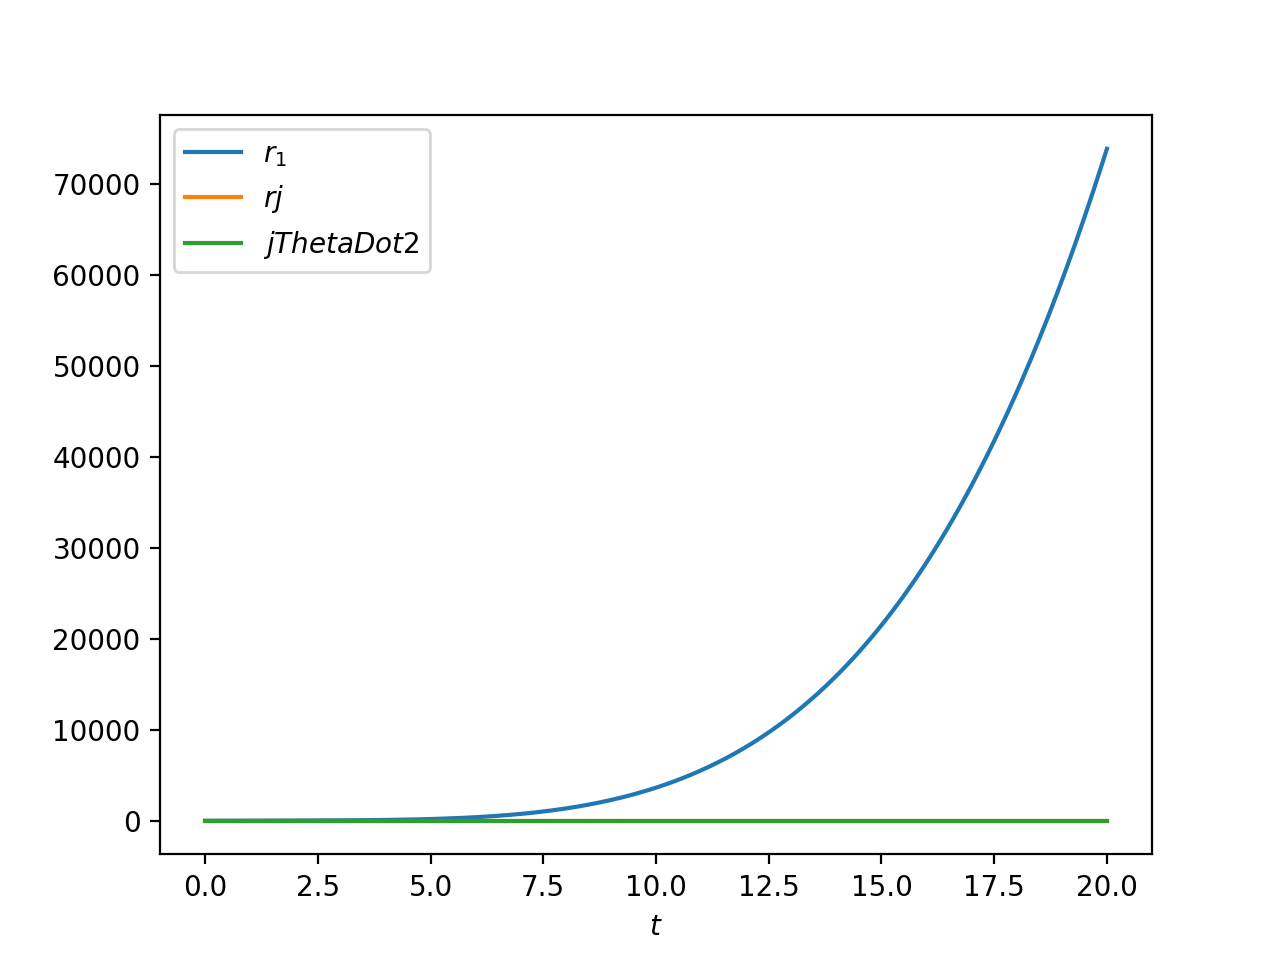

In [6]:
rest = (0,0,0,0)
times = np.linspace(0, 20, 401) #y = r, rDot, rj, rjDot, theta, thetaDot, jTheta, jThetaDot2 = Y  
sol1 = pluto().solve((5.2, 0, 5.2, 0, 0.1, 3, 0, 3), (0,1)).plot(times, ['r', 'rj', 'jThetaDot2']);


In [ ]:
sol1.animate(200);

In [ ]:
sol2 = Carts(mu=1, Omega=1.4, D=0.2).solve(rest, (0,20)).plot(times, ['x1', 'x2']);

That's interesting. When $\Omega = 1$, the two masses appear to be moving with about the same phase, but when $\Omega = 1.4$, mass 1 lags behind mass 2 by almost 90°. 

<IPython.core.display.Javascript object>


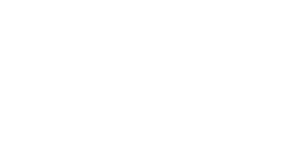

In [32]:
sol3 = Carts(mu=1, Omega=2).solve(rest, (0,20)).plot(times, ['x1', 'x2'], figsize=(8,5));

Another interesting development: at $\Omega = 2$ the amplitude of motion of mass 1 is now smaller than the amplitude for mass 2. We should prepare a plot of the amplitude and phase of each cart's motion with respect to the drive as a function of frequency. We could do that simulating for a while and then looking at the oscillations at the end of the run.

In [33]:
def find_amplitude_and_phase(**kwargs):
    t_max = 49.750
    sol = Carts(**kwargs)
    sol.solve((0,0,0,0), (0, t_max))
    # Now we need to extract the amplitude and phase for x1 and x2
    # We can do that by restarting the solution using the end point as the initial condition
    Y0 = sol(t_max)
    period = 2 * np.pi / sol.ω
    t_range = (t_max, t_max + 1.5 * period)
    sol2 = Carts(**kwargs)
    sol2.events = [lambda t, Y, args: Y[0], lambda t, Y, args: Y[2]]
    sol2.solve(Y0, t_range)
    t0 = period * np.floor(t_max / period)
    try:
        t1 = sol2.solution.t_events[0][0]
    except:
        print(sol2.solution)
    def adjust_phase(ϕ):
        two_pi = 2 * np.pi
        while ϕ > 0: ϕ -= two_pi
        while ϕ < -two_pi: ϕ += two_pi
        return ϕ
            
    ϕ1 = (t0 - t1) * sol2.ω + (0 if sol2.solution.y_events[0][0,1] > 0 else np.pi)
    A1 = np.abs(sol2(t1 + 0.25 * period)[0])
    t2 = sol2.solution.t_events[1][0]
    ϕ2 = (t0 - t2) * sol2.ω + (0 if sol2.solution.y_events[1][0,3] > 0 else np.pi)
    A2 = np.abs(sol2(t2 + 0.25 * period)[2])
    return (A1, adjust_phase(ϕ1), A2, adjust_phase(ϕ2))

In [34]:
find_amplitude_and_phase(Omega=1.4)

(1.0015394961130408,
 -3.1303752816674857,
 0.2832781563252693,
 -1.7014757270294423)

In [35]:
Omegas = 10**np.linspace(-1,1,101)
results = np.array([find_amplitude_and_phase(Omega=x) for x in Omegas])

<IPython.core.display.Javascript object>


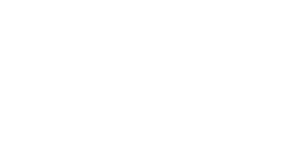

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))
amps, phases = axes
amps.loglog(Omegas, results[:,0], label=r'$|A_1|$')
amps.loglog(Omegas, results[:,2], label=r'$|A_2|$')
amps.set_xlabel(r"$\omega/\omega_0$")
amps.legend()
amps.grid()
phases.semilogx(Omegas, np.degrees(results[:,1]), label=r'$\phi_1$')
phases.semilogx(Omegas, np.degrees(results[:,3]), label=r'$\phi_2$')
phases.legend()
phases.set_yticks(np.linspace(-360, 0, 5))
phases.grid()
phases.set_xlabel(r"$\omega/\omega_0$");

Very interesting! We see two resonance peaks in the motion of the two carts: one at $\Omega = \omega/\omega_0 = 1$ and one at $\Omega \approx 1.7$. Let's zoom in a make a close-up plot of this interesting region.

<IPython.core.display.Javascript object>


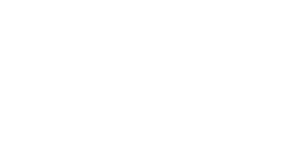

In [37]:
Omegas2 = np.linspace(0.8,2,101)
results = np.array([find_amplitude_and_phase(Omega=x) for x in Omegas2])
fig, axes = plt.subplots(2, 1, figsize=(8,8), sharex=True)
amps, phases = axes
amps.semilogy(Omegas2, results[:,0], label=r'$|A_1|$')
amps.semilogy(Omegas2, results[:,2], label=r'$|A_2|$')
amps.legend()
phases.plot(Omegas2, np.degrees(results[:,1]), label=r'$\phi_1$')
phases.plot(Omegas2, np.degrees(results[:,3]), label=r'$\phi_2$')
phases.legend()
phases.set_yticks(np.linspace(-360,0,5))
phases.grid()
phases.set_xlabel(r"$\omega/\omega_0$");

Can you explain this behavior?

Other things to explore:
- Can you calculate an analytic solution and compare it with the numerical results?
- Does it matter which cart has the damper?
- What does the phase plot tell us?
- How does the mass ratio influence the plots?
- ...

# Animation

Let’s see if we can't animate the motion of the carts. We will need to figure out how to show the two carts and drive. If we’re hard core, we may also figure out how to draw the springs. Rather than replacing the old class, I'll just define a new one here. Not sure why!

<IPython.core.display.Javascript object>


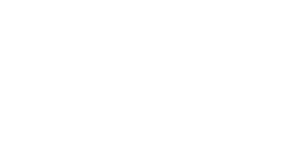

In [38]:
csol = Carts(mu=1, Omega=2)
csol.solve((0,0,0,0), (0, 10))
tvals = np.linspace(0, 10, 400)
csol.plot(tvals, ['x1', 'x2']);

<IPython.core.display.Javascript object>


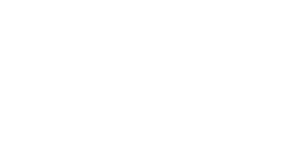

In [39]:
csol.animate(300, time_range=(0,10));

<IPython.core.display.Javascript object>


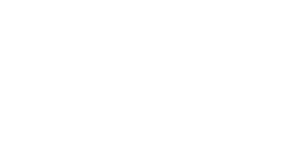

In [40]:
csol2 = Carts(mu=1, Omega=1.41).solve((0,0,0,0),(0, 10)).plot(np.linspace(0, 10, 400), ['x1', 'x2']);

<IPython.core.display.Javascript object>


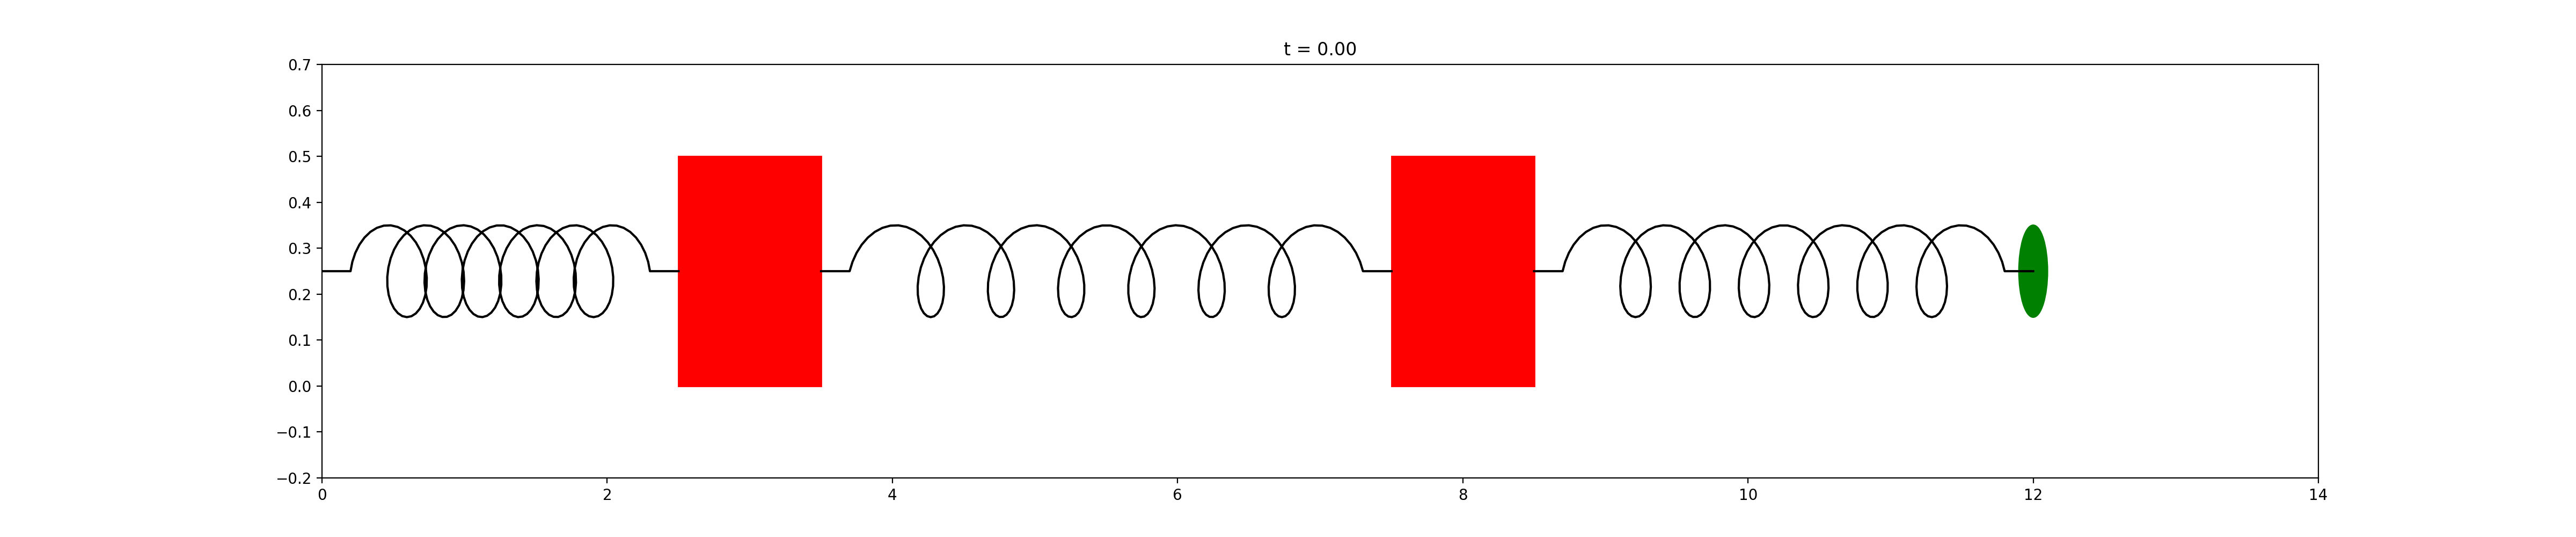

In [41]:
plt.close('all')
csol2.animate(300, time_range=(0, 10));